# カラーのアニメの顔画像を認識する

初音ミクを認識するNNを作ってみる。データは「アニメデータ整理」を参照。

imgsにrgbの画像データが`[r,g,b]`で[28*28]+[28*28]+[28*28]のvenctorデータとして保存されている。
（つまりこのvectorを3分割すると、RGBそれぞれのベクトルが取得でき、つぎに28分割するとRGBそれぞれのMatrixが手に入り、
各RGBのMatrixの足し算が元画像に対応する）

それに対して、flagsは初音ミクなら1、そうじゃなければ0が入っている

In [1]:
import random
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from PIL import Image
from os.path import join, relpath
from glob import glob
from sklearn.cross_validation import train_test_split

import pandas as pd
import urllib.request
import urllib
import urllib.parse 

%matplotlib inline
from matplotlib import pylab as plt
from PIL import Image

In [2]:
def draw_rgb(data, size=28):
    data = data.reshape(3,28,28) # 3分割して、28x28分割している
    data = data.transpose(1, 2, 0)*255
    pil_image = Image.fromarray(np.clip(data, 0, 255).astype(np.uint8))
    plt.imshow( pil_image )

In [3]:
imgs = np.loadtxt( 'square_animeface_28/imgs' ).astype("float32")
flags = np.loadtxt( 'square_animeface_28/flags' ).astype("int32")

In [4]:
# テストデータとトレーニングデータを分ける
X_train, X_test, Y_train, Y_test = train_test_split(imgs, flags, test_size=0.1, random_state=0)

0


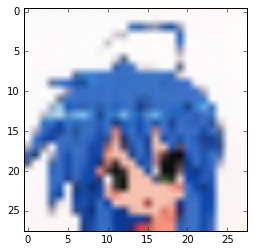

In [8]:
#画像を見てみる
draw_rgb(X_train[0])
print(Y_train[0])

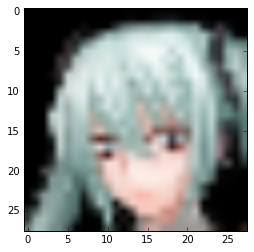

In [21]:
# 初音ミクはこちら
for image, y in zip(X_train, Y_train):
    if y == 1:
        draw_rgb(image)
        break

In [22]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            conv1=L.Convolution2D(3, 20, 5),
            conv2=L.Convolution2D(20,50, 5),
            l1 = L.Linear(800, 500),
            l2 = L.Linear(500, 2)
        )
        self.train = False
        
    def __call__(self, x):
        c1 = F.max_pooling_2d(F.relu(self.conv1(x)),  2)
        c2 = F.max_pooling_2d(F.relu(self.conv2(c1)),  2)
        h1 = F.relu(self.l1(c2))
        h1d = F.dropout(h1, train=self.train)
        return self.l2(h1d)

In [23]:
model = L.Classifier(CNN())
optimizer = optimizers.Adam()
optimizer.setup(model)

In [24]:
batch_size = 100
epoch = 401
model.zerograds()
model.predictor.train = True
for step in range(epoch):
    batch_index = np.random.randint(len(X_train)-batch_size)
    batch_x =X_train[batch_index:batch_index+batch_size]
    batch_x = Variable(batch_x.reshape((len(batch_x), 3, 28,28)))
    batch_y = Variable(Y_train[batch_index:batch_index+batch_size])
    optimizer.update(model, batch_x, batch_y)
    if step % ((epoch-1)/10) == 0:
        print ("step", str(step) ,"スタート: ", model.accuracy.data, "%" )
serializers.save_npz('anime_cnn_color.model', model)

step 0 スタート:  0.8899999856948853 %
step 40 スタート:  1.0 %
step 80 スタート:  1.0 %
step 120 スタート:  0.9900000095367432 %
step 160 スタート:  1.0 %
step 200 スタート:  1.0 %
step 240 スタート:  1.0 %
step 280 スタート:  1.0 %
step 320 スタート:  1.0 %
step 360 スタート:  1.0 %
step 400 スタート:  1.0 %


精度→ 1.0


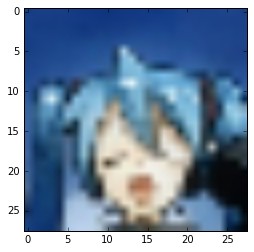

In [25]:
model.predictor.train = False
model(Variable(X_test.reshape(len(X_test), 3, 28, 28)), Variable(Y_test))
print("精度→",model.accuracy.data)
for data, image, y in zip(F.softmax(model.y).data, X_test, Y_test) :
    if data[0] < data[1]:
        draw_rgb(image)

なかなかの精度である